In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal
import scipy.integrate as integrate

<h1 align="center"><b><u>Lecture 11 - MCMC in Infinite Dimensional Space</u></b></h1>

<h2>Comparing Standard Gaussian Random Walk method to pCN method</h2>

Methods for performing MCMC on function spaces are explored in this notebook.  The example adapted from a part III essay linked on Moodle.  The example estimates a probability density based on samples that can be drawn from it, by using MCMC to sample from the Fourier series coefficients of the density function. 

Let the density to be estimated be:

$$
p(x) \propto \mathcal{N}(-3,1)\mathbb{1}_{[-10,10]} + \mathcal{N}(3,1)\mathbb{1}_{[-10,10]}
$$

it is assmued we have not access to the form of the density but can draw samples from it.  The Fourier series over this interval can be written as:

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos \left( \frac{2 \pi n (x-10)}{20} \right) + b_n \sin \left( \frac{2 \pi n (x-10)}{20} \right)
$$

Truncating this infinite series after $N$ terms leads to an approximation to the function, which is improved with increasing $N$.  This will allow us to see how the different MCMC methods compare with increased "mesh refinement"/dimension of the problem, i.e. increasing $N$.

To begin the MCMC sampling, a centered Gaussian process prior $\mu_0$ is defined on the function space - $\mathcal{N}(0,C)$, with covariance operator $C$.  To understand how this translates to a prior over the Fourier coefficients, the Karhunen-Loève expansion is employed - it details how a random process can be decomposed into orthonormal eigenfunctions.  These eignenfunctions are described uniquely by the covariance function, and can be thought of as similar to the Fourier basis functions.  The covariance matrix for the coefficients is given by:

$$
C_{ij} = 
\begin{cases}
\frac{1}{i+1} \text{ if } i=j\\
0 \text{ otherwise}
\end{cases}
$$

In [31]:
# True density
def f_true(x):
    return np.exp(-(1/2)*pow(x-3,2)) + np.exp(-(1/2)*pow(x+3,2))

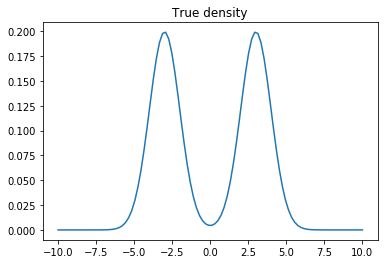

In [32]:
## Plotting
xs = np.linspace(-10,10,100)
plt.plot(xs,f_true(xs)/integrate.quad(lambda x: f_true(x), -10, 10)[0])
plt.title("True density")
plt.show()

In [33]:
def draw_sample(dim_y):
    sample = []
    
    while len(sample)<dim_y:
        p = uniform.rvs()
        
        # Sample from both Gaussians with equal prob
        if p>0.5:
            new = norm.rvs(loc=3,scale=1)
        else:
            new = norm.rvs(loc=-3,scale=1)
        # Only include sample if in [-10,10]
        if new>-10 and new<10:
            sample.append(new)
    
    return sample

The function $u$ maps the Fourier coefficients $xi$ and the input $x$ to a value.  $u(x)$ is the logarithm of the estimated density $f$, which is what is being approximated here.

In [3]:
def u(x,xi):
    out = 0
    for i, c in enumerate(xi):
        # Shifted fourier series to span [-10,10]
        if i%2==0:
            out += c*np.cos(2*np.pi*(i/2)*(x-10)/(10*2))
        else:
            out += c*np.sin(2*np.pi*(i+1/2)*(x-10)/(10*2))
    return out

In [4]:
# Density approximation
def f(x,xi):
    f = u(x,xi)
    return np.exp(f)

The infinite dimensional MCMC algorithm given in the lecture notes descibes the standard acceptance probability as:

$$
\alpha(u,v) = \min(1, I(u) - I(v))
$$

with 

$$
I(u) = \Phi(u) + \frac{1}{2}|C^{-\frac{1}{2}}u|^2
$$



Below is the function $\Phi$, which from the lecture slides is realted to the likelihood of $u$.
$$
\frac{d\mu}{d\mu_0}(u) \propto L(u) = \exp(-\Phi(u))
$$

The approximate density formed by the exponential of the truncated Fourier series given by $xi$ must be integrated to find the normalising constant so that the likelihood can be evaluated.

In [6]:
def Phi(xi,y):
    dim_y = len(y)
    phi_u = 0
    
    # Find normalising const given xi
    Z = integrate.quad(lambda x: f(x,xi), -10, 10)[0]
    
    for yj in y:
        phi_u += np.log( np.exp(u(yj, xi))/Z )
        
    return -phi_u

In [7]:
def I(xi,y):
    # Computing 1/2|C^1/2 u|^2 + Phi(u)
    return (1/2)*sum([(i+1)*pow(x,2) for i,x in enumerate(xi)]) + Phi(xi,y)

The two methods for performing MCMC in the function space considered here are the Standard (Gaussian) Random Walk (SRW), and the preconditioned Crank-Nicolson (pCN) method.  The forms of the acceptance probability are seen in the lecture notes, and are given below.

SRW
$$
\alpha(u,v) = \min(1, I(u) - I(v))
$$

pCN
$$
\alpha(u,v) = \min(1, \Phi(u) - \Phi(v))
$$

with corresponding proposals:

SRW
$$
v^{(k)} =  u^{(k)} + \beta \eta^{(k)}, \eta^{(k)} \sim \mathcal{N}(0,C)
$$

pCN
$$
v^{(k)} =  u^{(k)}\sqrt{1-\beta^2}  + \beta \eta^{(k)}, \eta^{(k)} \sim \mathcal{N}(0,C)
$$

In [8]:
def acceptance_SRW(xi_u, xi_v, y):
    return min(1, np.exp( I(xi_u, y) - I(xi_v, y) ) )

In [9]:
def acceptance_pCN(xi_u, xi_v, y):
    return min(1, np.exp( Phi(xi_u, y) - Phi(xi_v, y) ) )

The MCMC method is then defined as a function below.

In [10]:
def mcmc(xi, y, C, N, beta, method="pCN"):
    
    samples = []
    acc = 0
    
    xi_prev = xi
    
    for _ in range(N):
        # Propose new sample based on selected method
        if method=="pCN":
            xi_new = np.sqrt(1-pow(beta,2))*xi_prev + beta*multivariate_normal.rvs(np.zeros(len(xi)), C)
            a = acceptance_pCN(xi_prev, xi_new, y)
        if method=="SRW":
            xi_new = xi_prev + beta*multivariate_normal.rvs(np.zeros(len(xi)), C)
            a = acceptance_SRW(xi_prev, xi_new, y)
            
        u = uniform.rvs()
        if u<a:
            # Accept sample
            samples.append(xi_new)
            xi_prev = xi_new
            acc += 1
        else:
            samples.append(xi_prev)
            
    return samples, acc/N

In [11]:
N = 200
dim_u = 30
dim_y = 100

# Initial guess
xi = np.zeros(dim_u)
xi[0] = 1

# Generate covariance matrix for xi
C = np.diag( [1/(i+1) for i in range(dim_u)] )

# Generate sample
y = draw_sample(dim_y)

The samples are drawn from the true density, which are plotted as a histogram below.

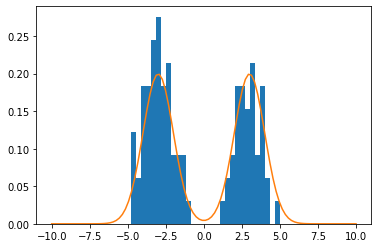

In [12]:
## Plotting
plt.hist(y,bins=30,density="probability")
plt.plot(xs,f_true(xs)/integrate.quad(lambda x: f_true(x), -10, 10)[0])
plt.show()

In [13]:
samples, acc_rate = mcmc(xi, y, C, N, 0.2, method='pCN')

In [14]:
# Average the samples with a burn in of N/2
samples_avg = sum(samples[int(N/2):])/(N/2)

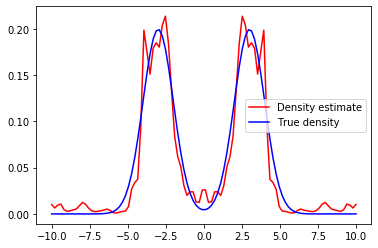

In [15]:
plt.plot(xs,f(xs,samples_avg)/integrate.quad(lambda x: f(x,samples_avg), -10, 10)[0], color='r', label='Density estimate')
plt.plot(xs,f_true(xs)/integrate.quad(lambda x: f_true(x), -10, 10)[0], color='b', label='True density')
plt.legend()
plt.show()

In [16]:
acc_rate

0.415

The denisty esitmate can be seen to be close to the true density - adjust the burn-in and the dimension of $xi$ (where the series is truncated) to see how it affect the resulting estimate.

<h2>Robustness of pCN to "Mesh Refinement"</h2>

This code can take a long time to run to produce the required plots, since many samples must be taken, at many different values of $\beta$ to get a clear picture.  The image used here has been produced previously, and the code added below for reference.

As discussed in the lecture slides, the acceptance probability does not degenerate with dimension when using the pCN method, but it clearly degenerating when using the standard random walk.

<img src="srw_pcn.png">

In [37]:
N = 200
# Range of betas to test
bs = np.logspace(-3,0,5)
# Increasing dimension to compare pCN and SRW
dims = [10,40,160]

In [38]:
def eval_acc(mcmc_method="pCN"):
    results = []
    for dim_u in dims:
        accs = []
        for beta in bs:
            # Initial guess
            xi = np.zeros(dim_u)
            xi[0] = 1

            # Generate covariance matrix for xi
            C = np.diag( [1/(i+1) for i in range(dim_u)] )

            # Generate sample
            y = draw_sample(dim_y)

            samples, acc_rate = mcmc(xi, y, C, N, 0.2, method=mcmc_method)
            
        results.append( (dim_u, accs) )
        
    return results

In [39]:
#results_pCN = eval_acc(mcmc_method="pCN")
#results_SRW = eval_acc(mcmc_method="SRW")

In [40]:
#fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
#for result in results_SRW
#    ax1.plot(bs,result[1],label=r"$d_u = $ {}".format(result[0]))
#for result in results_pCN
#    ax2.plot(bs,result[1],label=r"$d_u = $ {}".format(result[0]))
#ax1.set_xscale('log')
#ax2.set_xscale('log')
#ax1.legend()
#ax2.legend()
#plt.show()